In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import numpy as jnp
import numpy as np
from functools import partial
from jax import random
import jax
from matplotlib import pyplot as plt

key = random.PRNGKey(42)

# 3D Helmholtz equation solver

Running 3D simulations should be just as easy as adding an extra dimension to a 2D simulation script, where appropriate

In [83]:
def show_field(field):
    fig, axes = plt.subplots(2,1,figsize=(15,8))
    
    maxval = jnp.amax(jnp.abs(field))
    print("Max val:", maxval)

    axes[0].imshow(field.real, vmin=-maxval, vmax=maxval, cmap="seismic")
    axes[0].set_title("Real wavefield")
    axes[1].imshow(jnp.abs(field), vmin=0, vmax=maxval, cmap="magma")
    axes[1].set_title("Wavefield magnitude")

In [85]:
# Defining geometry
from jwave.geometry import Domain, Medium, _circ_mask

N = (256, 512)         # Grid size
dx = (1., 1.)          # Spatial resolution

src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[128-10:128+10,50].set(1.0)
    
omega = 1.            # Wavefield omega = 2*pi*f

# Making geometry
domain = Domain(N, dx)

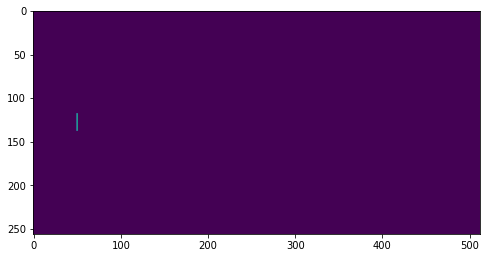

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(src_field.real)

In [87]:
from jwave.acoustics import ongrid_helmholtz_solver
from jax import jit

def setup_simulation(medium, src_field, solver="gmres"):
    params, solver = ongrid_helmholtz_solver(
        medium, 
        omega=omega,
        tol=1e-5, 
        restart=20,
        method=solver,
        maxiter=1000,
        source = src_field
    )
    return params, jit(solver)

In [88]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[60:190,40:280].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 70,[110,280]))*(1-_circ_mask(N,100,[135,44])) +1
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=None,
    pml_size=30
)

Max val: 0.7933733


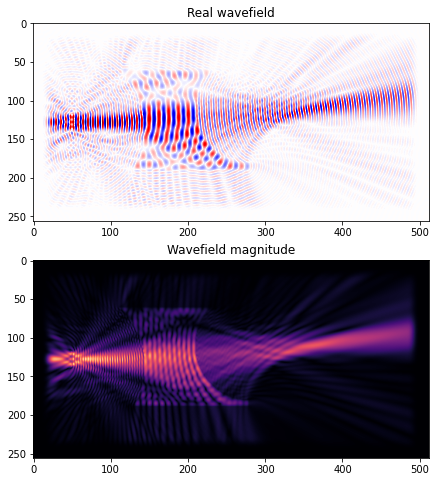

In [89]:
params, solver = setup_simulation(medium, src_field, "gmres")
field = solver(params)

Max val: 0.7933733


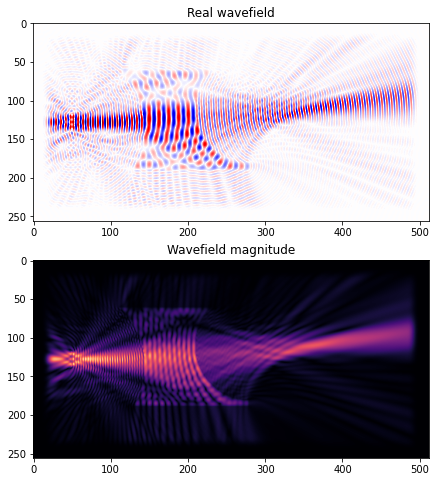

In [90]:
show_field(field)

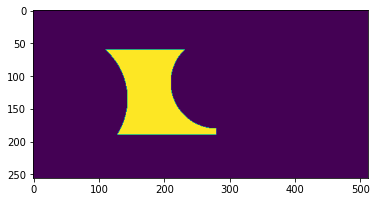

In [78]:
plt.imshow(sound_speed)

### Simple downscaling

In [91]:
# Defining geometry
from jwave.geometry import Domain, Medium, _circ_mask

N = (128, 256)         # Grid size
dx = (2., 2.)          # Spatial resolution
src_loc = [64, 25]
omega = 1             # Wavefield omega = 2*pi*f

# Making geometry
domain = Domain(N, dx)

def downscale(x):
    return 0.25*(x[0::2,0::2]+x[1::2,0::2]+x[0::2,1::2]+x[1::2,1::2])

src_field_small = downscale(src_field)

In [92]:
# Constructing medium physical properties
sos = downscale(sound_speed)
medium = Medium(
    domain=domain,
    sound_speed=sos,
    density=1.,
    attenuation=None,
    pml_size=15
)

In [93]:
src_field.shape

(256, 512)

Max val: 0.7461749


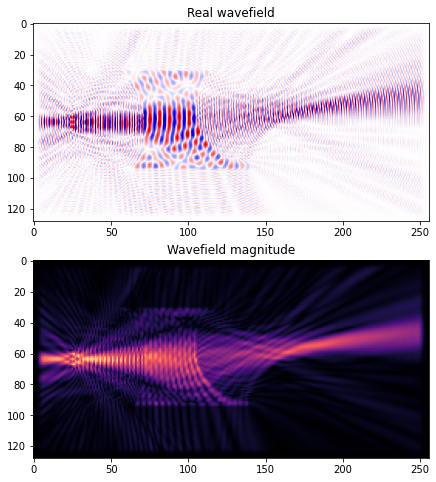

In [94]:
params, solver = setup_simulation(medium, src_field_small, "gmres")
field_small = solver(params)
show_field(field_small)

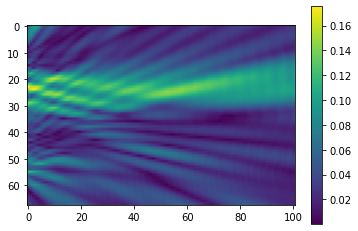

In [100]:
target_field = field[1::2,1::2][30:-30,140:-15]
T = jnp.amax(jnp.abs(target_field))
plt.imshow(jnp.abs(field_small - field[1::2,0::2])[30:-30,140:-15]/T)
plt.colorbar()

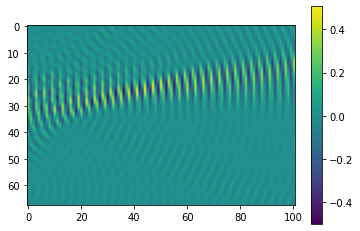

In [101]:
plt.imshow(jnp.real(target_field))
plt.colorbar()

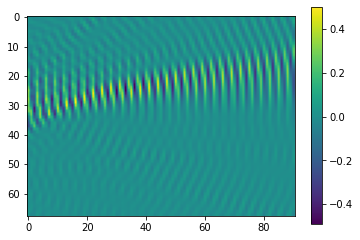

In [102]:
plt.imshow(jnp.real(field_small[30:-30,150:-15]))
plt.colorbar()

## Optimize the sos map

In [140]:
def make_sos(params):
    x = jnp.zeros(N).at[20:105,40:130].set(jax.nn.sigmoid(params)) + 1
    return x

def inv_sigmoid(x):
    return jnp.log((x+1e-4)/(1-x))

sos_map_params = inv_sigmoid(0.95*sos[20:105,40:130]-0.95 + 0.01)

target_field = field[0::2,0::2][15:-15,140]

def loss(theta, tol):
    #medium = Medium(
    #    domain=domain,
    #    sound_speed=make_sos(theta),
    #    density=1.,
    #    attenuation=None,
    #    pml_size=8
    #)
    #params, solver = setup_simulation(medium, "gmres")
    params["c"] = jnp.expand_dims(make_sos(theta), -1)
    params["solver_params"]["tol"] = tol
    field_small = solver(params)
    lossval = jnp.sum(jnp.abs(field_small[15:-15,140] - target_field)**2)/T
    return lossval

loss_with_grad = jax.value_and_grad(loss)

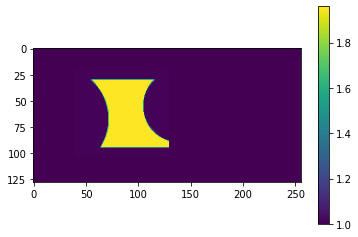

In [141]:
plt.imshow(make_sos(sos_map_params))
plt.colorbar()

In [142]:
medium = Medium(
    domain=domain,
    sound_speed=make_sos(sos_map_params),
    density=1.,
    attenuation=None,
    pml_size=30
)
params, solver = setup_simulation(medium, src_field_small, "gmres")
#params["c"] = jnp.expand_dims(make_sos(theta), -1)
field_small = solver(params)

Max val: 0.75165594


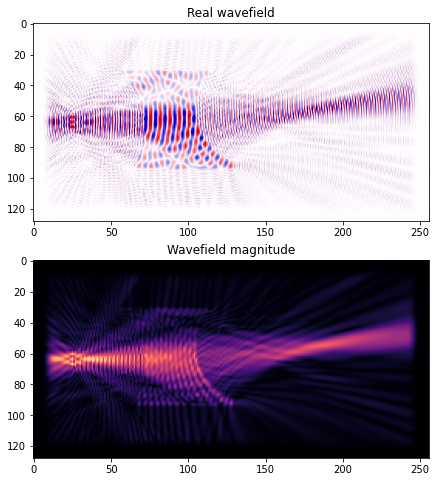

In [143]:
show_field(field_small)

In [144]:
params["solver_params"]

{'tol': 1e-05, 'maxiter': 1000}

In [145]:
from jax.experimental import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.01, b1=0.9, b2=0.95)
opt_state = init_fun(sos_map_params)

@partial(jit, static_argnums=(1,))
def update(opt_state,tol):
    lossval, gradient = loss_with_grad(get_params(opt_state), tol)
    return lossval, update_fun(k, gradient, opt_state)

pbar = tqdm(range(1000))
tol = 1e-3
for k in pbar:
    lossval, opt_state = update(opt_state, tol)
    
    if k == 0:
        avg_loss = lossval
    else:
        avg_loss = 0.9*avg_loss + 0.1*lossval
        
    if lossval > avg_loss:
        tol = max([tol/10, 1e-5])
        
    # For logging
    pbar.set_description("Tol: {} | Avg. ampl: {:01.5f} | Ampl: {:01.5f}".format(tol, avg_loss, lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Tol: 0.0001 | Avg. ampl: 0.01401 | Ampl: 0.01400:  58%|▌| 583/1000 [08:05<05:47, 


KeyboardInterrupt: 

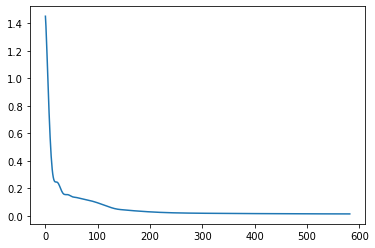

In [146]:
plt.plot(losshistory)

In [147]:
medium = Medium(
    domain=domain,
    sound_speed=make_sos(get_params(opt_state)),
    density=1.,
    attenuation=None,
    pml_size=30
)
params, solver = setup_simulation(medium, src_field_small, "gmres")
#params["c"] = jnp.expand_dims(make_sos(theta), -1)
field_small = solver(params)

Max val: 0.9809948


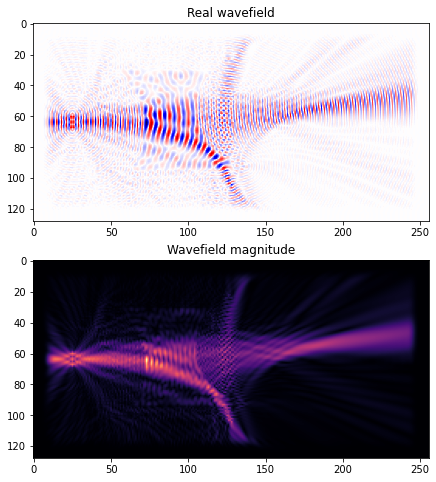

In [148]:
show_field(field_small)

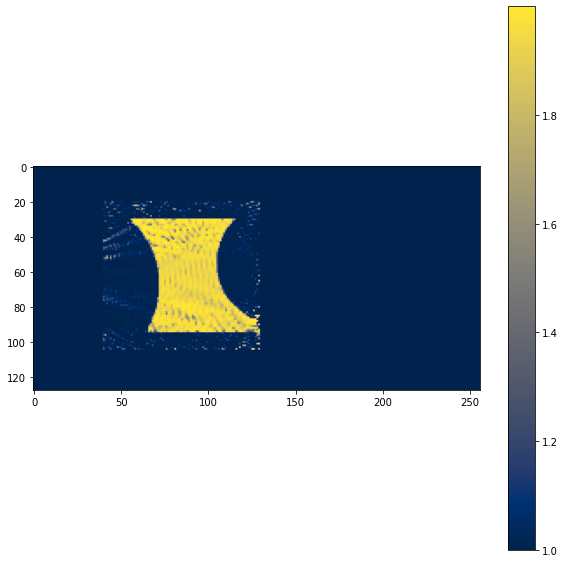

In [151]:
plt.figure(figsize=(10,10))
plt.imshow(make_sos(get_params(opt_state)), cmap="cividis")
plt.colorbar()

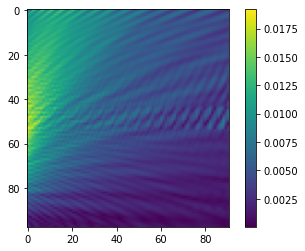

In [150]:
plt.imshow(jnp.abs(field_small - field[0::2,0::2])[15:-15,150:-15]/T)
plt.colorbar()

In [ ]:
show_field(field_small)

In [19]:
print("Runtime with GMRES")
%timeit solver(params).block_until_ready()

Runtime with GMRES
916 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
params, solver = setup_simulation(medium, "bicgstab")
field = solver(params)

print("Runtime with BiCGSTAB")
%timeit solver(params).block_until_ready()

Runtime with BiCGSTAB
168 ms ± 680 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=None,
    pml_size=15
)

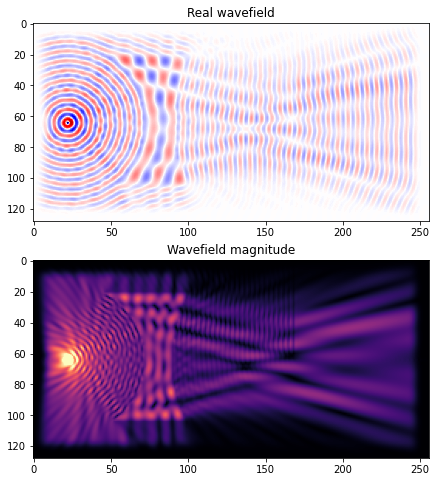

In [22]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

In [26]:
attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:110,125:220].set(0.1)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=attenuation,
    pml_size=15
)

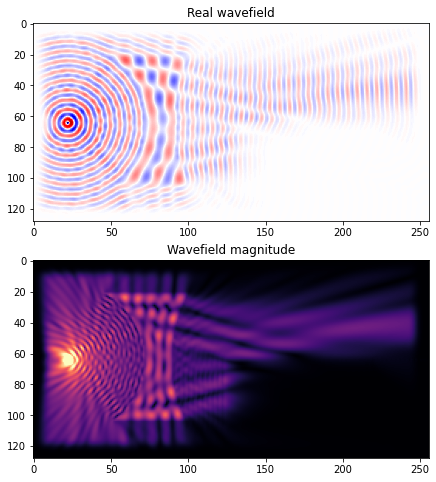

In [27]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

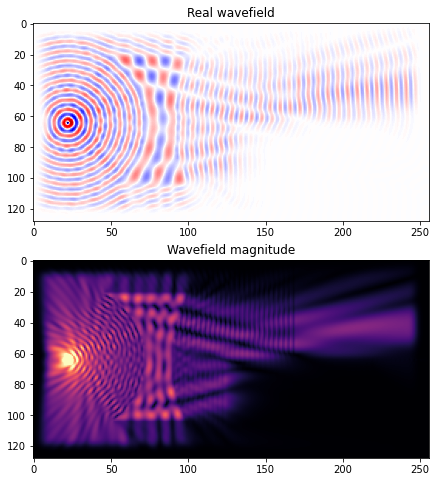

In [29]:
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15
)
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
show_field(field)

In [33]:
params, solver = ongrid_helmholtz_solver(
    medium, 
    omega=omega,
    tol=1e-5, 
    restart=5,
    method="gmres",
    maxiter=1000,
    source = src_field
)

solver = jit(solver)
field = solver(params)

Text(0.5, 1.0, 'Wavefield magnitude')

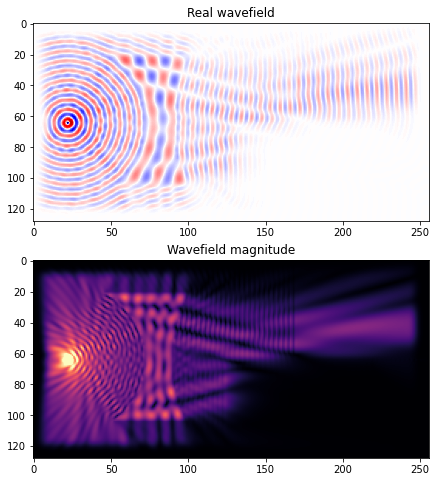

In [34]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
axes[1].set_title("Wavefield magnitude")